# Desafío - Machine Learning 

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from warnings import WarningMessage
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, scale



WarningMessage = False
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [11]:
data_web = pd.read_csv("data/usuarios_win_mac_lin_train.csv")
data_web.describe()

data_validation = pd.read_csv("data/data_validation_without_class.csv")

## Analisis de los datos

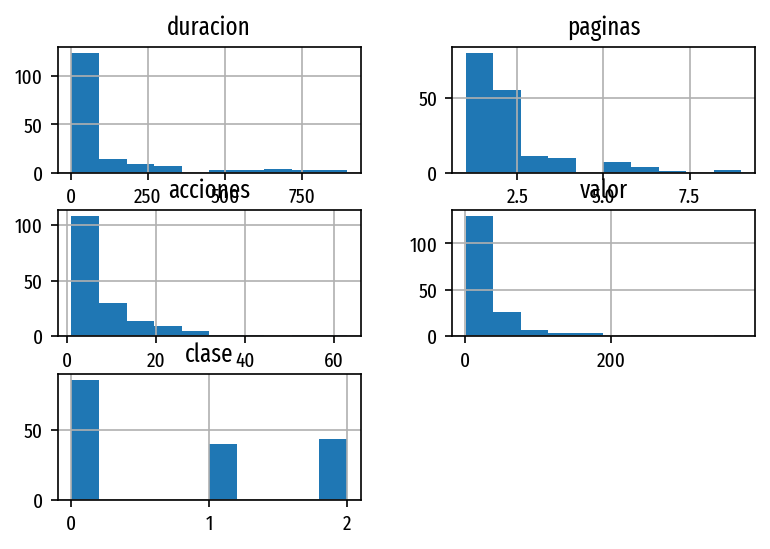

In [3]:
hist = data_web.hist(bins=10)

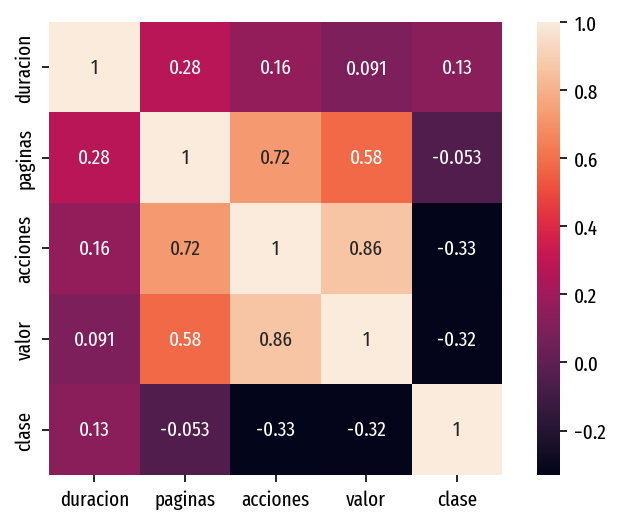

In [4]:
corr = data_web.corr()
sns.heatmap(corr, annot = True, square = True);

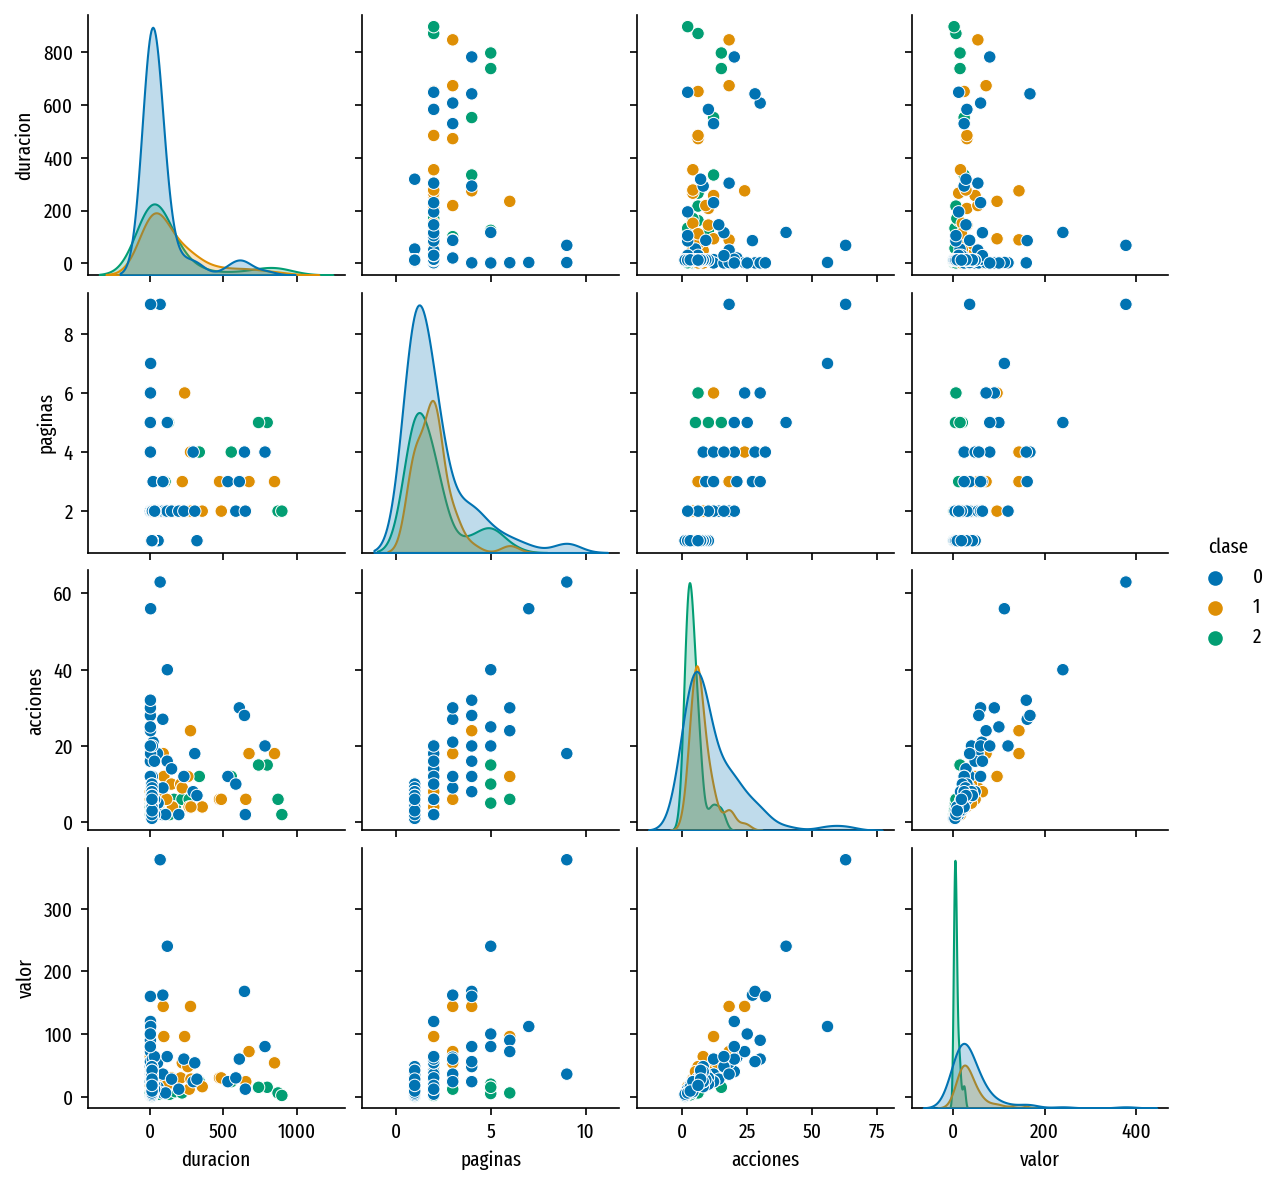

In [5]:
sns.pairplot(data_web, hue="clase", height = 2, palette = 'colorblind')

## Análisis de componentes principales (PCA)

In [12]:
# media de cada variable
print('Media de las variables')
print(data_web.mean(axis=0))
# Varianza
print('Varianza de las variables')
print(data_web.var(axis=0))

Media de las variables
duracion    111.075729
paginas       2.041176
acciones      8.723529
valor        32.676471
clase         0.752941
dtype: float64
Varianza de las variables
duracion    40987.298106
paginas         2.252732
acciones       83.467490
valor        2002.740863
clase           0.707832
dtype: float64


Hay que estandarizar los datos para que variables con alta media y varianza no dominen el PCA.

In [13]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA()) # Estandar Scaler estandariza, PCA obtiene componentes
pca_pipe.fit(data_web)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

In [18]:
modelo_pca.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

Convierto los componentes del modelo para analizar sus combinaciones lineales e importancia

In [19]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = data_web.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
)

,duracion,paginas,acciones,valor,clase
PC1,0.159889,0.505198,0.592426,0.558397,-0.237558
PC2,0.698859,0.273012,-0.044904,-0.123858,0.647845
PC3,0.682919,-0.254155,-0.105022,-0.136200,-0.662908
PC4,-0.139296,0.733213,-0.149168,-0.584695,-0.280848
PC5,-0.015825,-0.260850,0.783412,-0.558957,0.074435


Analisis visual

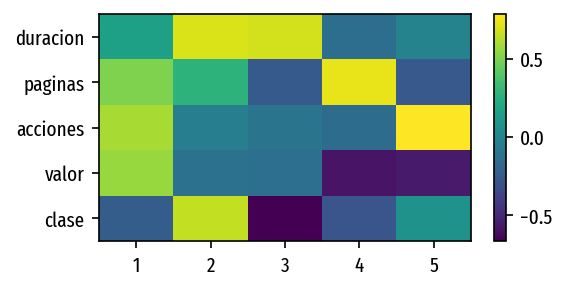

In [21]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(data_web.columns)), data_web.columns)
plt.xticks(range(len(data_web.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar()

In [36]:
len(modelo_pca.components_)

5

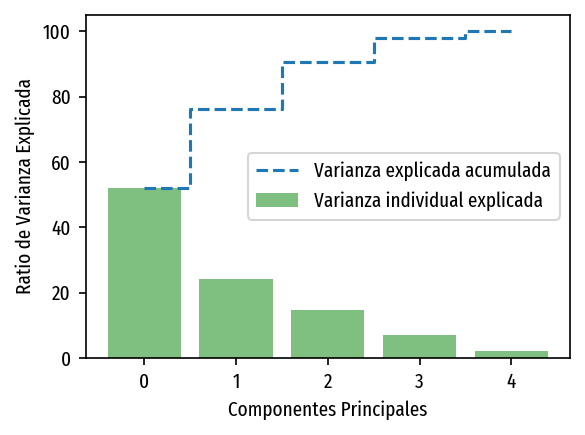

In [37]:
# A partir de los autovalores, calculamos la 
# varianza explicada (% representatividad)

var_exp = modelo_pca.explained_variance_ratio_ *100  # ratio de varianza explicada por 100 (para que quede en %)
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por componente 

n_components = len(modelo_pca.components_)
# Representamos en un diagrama de barras la varianza explicada por cada autovalor, y la acumulada
# with plt.style.context('seaborn-pastel'):
plt.figure(figsize=(4, 3))

plt.bar(range(n_components), var_exp, alpha=0.5, align='center',
        label='Varianza individual explicada', color='g')
plt.step(range(n_components), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
plt.ylabel('Ratio de Varianza Explicada')
plt.xlabel('Componentes Principales')
plt.legend(loc='best')
plt.tight_layout()

## Modelo

Clasificador DecisionTree

* Pendiente: Aplicar PCA antes 

In [22]:
X=data_web[['duracion', 'paginas', 'acciones', 'valor']]  # Features
y=data_web['clase']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y) 

In [23]:
# Con menos componentes
X=data_web[['acciones','valor']]  # Features
y=data_web['clase']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y) 

In [24]:
# Árbol de desición
modelo_tree=DecisionTreeClassifier(max_depth = 3, random_state = 1, )
# fit
modelo_tree.fit(X_train,y_train)

y_pred=modelo_tree.predict(X_test)

In [25]:
modelo_tree.feature_importances_

array([0.28670701, 0.71329299])

In [26]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6764705882352942


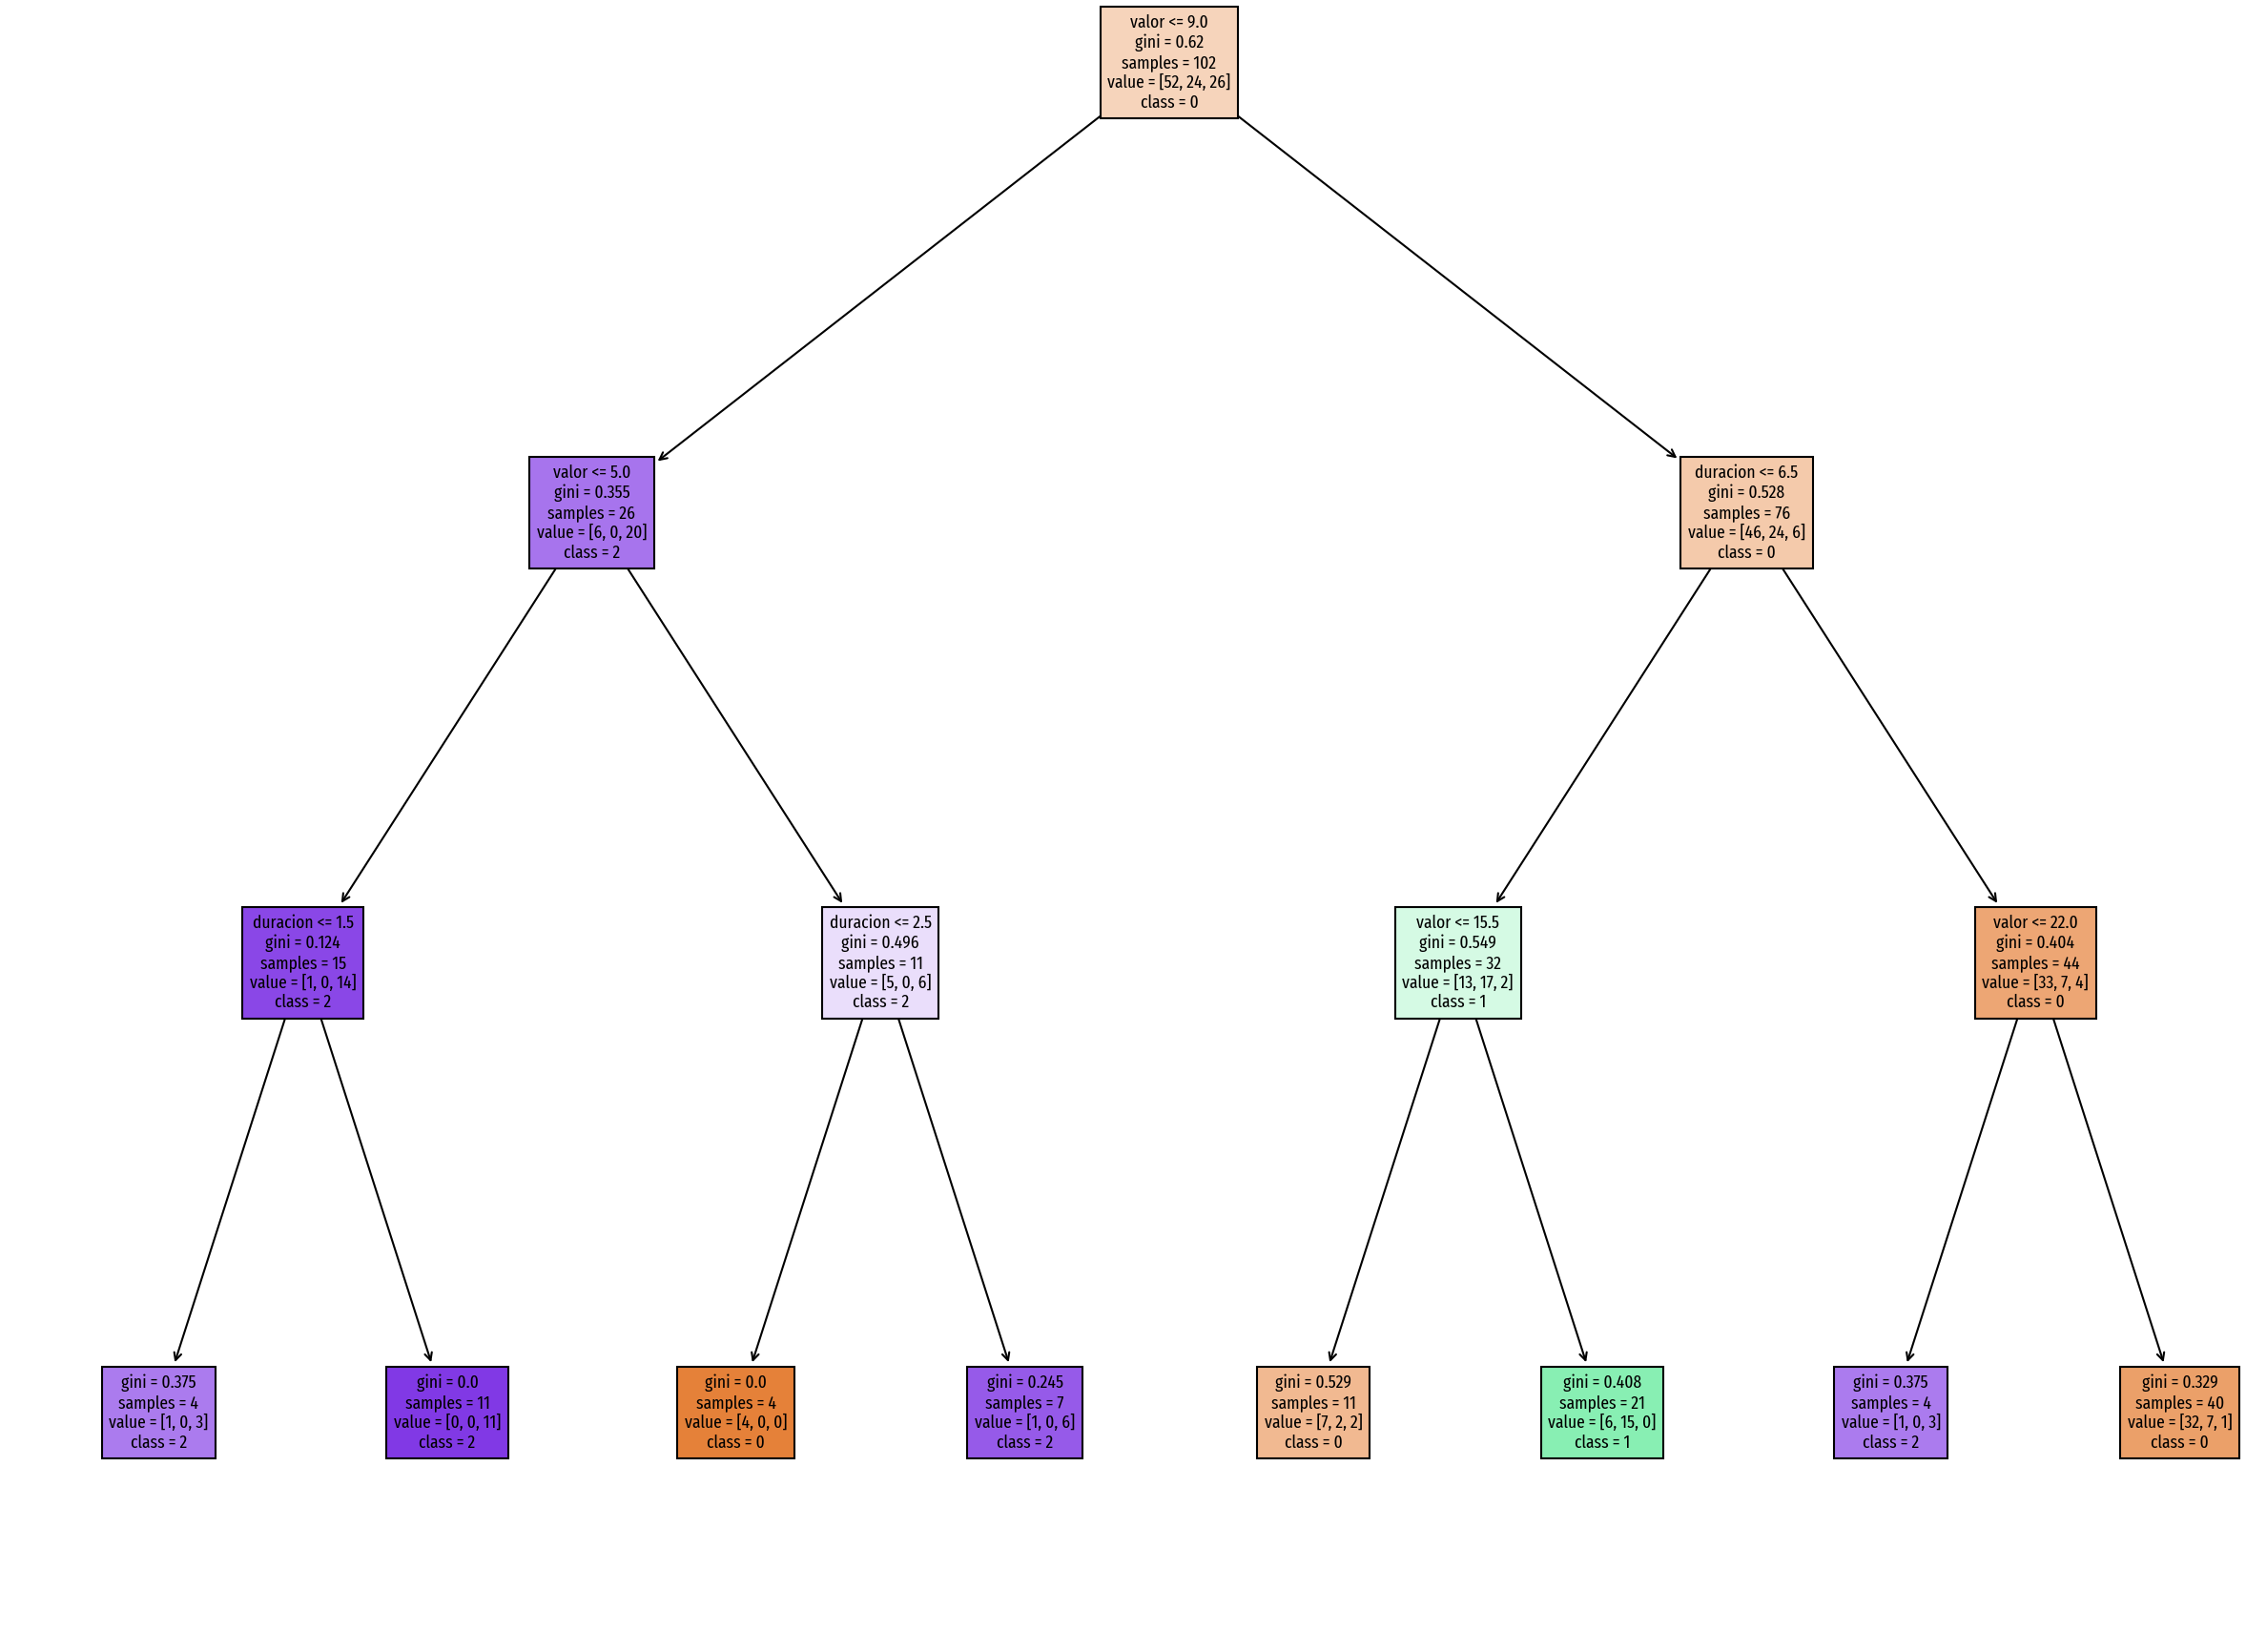

In [27]:
#fn = ['duracion', 'paginas', 'acciones', 'valor']
fn = ['duracion', 'valor']
cn = ["0", "1", "2"]

plt.figure(figsize = (10,8))
plot_tree(modelo_tree, feature_names = fn, class_names = cn, filled = True)
plt.tight_layout(h_pad=0.5, w_pad=0.5)

# Si el gini tiende a cero, el error tiende a cero

In [28]:
predicciones = modelo_tree.predict(X = X_test)
print(metrics.classification_report(y_true = y_test,
y_pred = predicciones
))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69        34
           1       0.64      0.44      0.52        16
           2       0.71      0.83      0.77        18

    accuracy                           0.68        68
   macro avg       0.67      0.66      0.66        68
weighted avg       0.67      0.68      0.67        68



# Modelo 2

Random Forest

In [29]:
modelo_rf =  RandomForestClassifier(
            n_estimators = 100,
            n_jobs       = -1,
            max_depth= 6,
            random_state = 1
         )
      
modelo_rf.fit(X_train.values, y_train.values)

RandomForestClassifier(max_depth=6, n_jobs=-1, random_state=1)

In [30]:
# Accuracy
# ==============================================================================
y_pred = modelo_rf.predict(X_test.values)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7058823529411765


In [31]:
predicciones = modelo_rf.predict(X = X_test.values)
print(metrics.classification_report(y_true = y_test,
y_pred = predicciones
))

              precision    recall  f1-score   support

           0       0.73      0.65      0.69        34
           1       0.60      0.56      0.58        16
           2       0.74      0.94      0.83        18

    accuracy                           0.71        68
   macro avg       0.69      0.72      0.70        68
weighted avg       0.70      0.71      0.70        68



In [115]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [100,150],
                 'max_features': [1,2],
                 'max_depth'   : [None,3, 6, 10],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train.values, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 6, 'max_features': 1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 6, 'max_features': 1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 6, 'max_features': 2, 'n_estimators': 100} ✓
Modelo: {'criterion'

,oob_accuracy,criterion,max_depth,max_features,n_estimators
31,0.764706,entropy,10.0,2,150
30,0.764706,entropy,10.0,2,100
27,0.764706,entropy,6.0,2,150
19,0.764706,entropy,NaN,2,150


In [48]:
# Error de test del modelo final
# ==============================================================================
modelo_rf =  RandomForestClassifier(
            n_estimators = 150,
            n_jobs       = -1,
            max_depth= 6,
            random_state = 1,
            max_features = 2,
            criterion='entropy'
         )

modelo_rf.fit(X_train.values, y_train)        

predicciones = modelo_rf.predict(X = X_test.values)
mat_confusion = metrics.confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = metrics.accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[21  7  6]
 [ 7  9  0]
 [ 1  0 17]]

El accuracy de test es: 69.11764705882352 %
